<a href="https://colab.research.google.com/github/jhj030722/til/blob/main/%EB%94%A5%EB%9F%AC%EB%8B%9D_week7_%EC%8B%A4%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 순환 신경망으로 IMDB 리뷰 분류하기

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/hg-mldl/blob/master/9-2.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩에서 실행하기</a>
  </td>
</table>

In [ ]:
# 실행마다 동일한 결과를 얻기 위해 케라스에 랜덤 시드를 사용하고 텐서플로 연산을 결정적으로 만듭니다.
import tensorflow as tf

tf.keras.utils.set_random_seed(42)

## IMDB 리뷰 데이터셋

IMDB 리뷰 데이터셋을 2가지 방법으로 변형하여 순환 신경망에 주입
- 원-핫 인코딩
- 단어 임베딩

<자연어 처리>

- NLP에서 훈련 데이터를 종종 corpus(말뭉치) 라고 함
- IMDB 데이터셋은 감성 분석에 해당
- 사실 텍스트 자체가 신경망에 전달되는 것은 X -> 컴퓨터는 모두 숫자로 데이터를 처리

- 텍스트 데이터의 경우 단어를 숫자 데이터로 바꾸는 방법은 등장하는 단어마다 고유한 정수를 매핑 하는 것이다. (정숫값 사이에는 어떠한 서열관계 X)
- 일반적으로 영어문장은 모두 소문자로 바꾸고 구둣점 삭제 후 공백을 기준으로 분리함
  - 이렇게 분리된 단어를 TOKEN 토큰이라고 부름
  - 하나의 샘플은 여러 개의 토큰으로 이루어져있고 1개의 토큰 = 1개의 타임스탬프에 해당
  - 토큰에 할당하는 정수 중 몇 개는 특정한 용도로 예약되어 있다
    - 0은 패딩
    - 1은 문장의 시작
    - 2는 어휘 사전에 없는 토큰
      - 어휘 사전이란? : 훈련 세트에서 고유한 단어를 뽑아 만든 목록

In [ ]:
# 텐서플로에는 이미 영어 문장을 정수로 바꾼 데이터가 포함되어 있음
# IMDB 모듈 임포트하여 데이터 로드

# 전체 데이터셋에서 가장 자주 등장하는 단어 500개만 사용

from tensorflow.keras.datasets import imdb

(train_input, train_target), (test_input, test_target) = imdb.load_data(
    num_words=200)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
print(train_input.shape, test_input.shape) # 훈련 세트와 테스트 세트의 크기 확인

(25000,) (25000,)


train과 test 세트가 각각 25000개의 샘플로 이루어져있다.

-> 리뷰 텍스트는 길이가 제각각 이므로 2차원 고정 크기의 배열에 담기보다
**리뷰마다 별도의 파이썬 리스트로 담아야 메모리를 효율적으로 사용**가능


`train_input : [리뷰1, 리뷰2, 리뷰3, ....]` <- 넘파이 배열

In [ ]:
print(len(train_input[0])) # 첫 번째 리뷰의 길이는 218개의 토큰으로 이루어져있음

218


In [ ]:
print(len(train_input[1])) # 두 번째 리뷰는 189개의 토큰으로 이루어져있음 (리뷰의 길이)

189


In [ ]:
print(train_input[0]) # 첫번째 리뷰에 담긴 내용 (영어 단어 -> 정수) 출력하기

[1, 14, 22, 16, 43, 2, 2, 2, 2, 65, 2, 2, 66, 2, 4, 173, 36, 2, 5, 25, 100, 43, 2, 112, 50, 2, 2, 9, 35, 2, 2, 5, 150, 4, 172, 112, 167, 2, 2, 2, 39, 4, 172, 2, 2, 17, 2, 38, 13, 2, 4, 192, 50, 16, 6, 147, 2, 19, 14, 22, 4, 2, 2, 2, 4, 22, 71, 87, 12, 16, 43, 2, 38, 76, 15, 13, 2, 4, 22, 17, 2, 17, 12, 16, 2, 18, 2, 5, 62, 2, 12, 8, 2, 8, 106, 5, 4, 2, 2, 16, 2, 66, 2, 33, 4, 130, 12, 16, 38, 2, 5, 25, 124, 51, 36, 135, 48, 25, 2, 33, 6, 22, 12, 2, 28, 77, 52, 5, 14, 2, 16, 82, 2, 8, 4, 107, 117, 2, 15, 2, 4, 2, 7, 2, 5, 2, 36, 71, 43, 2, 2, 26, 2, 2, 46, 7, 4, 2, 2, 13, 104, 88, 4, 2, 15, 2, 98, 32, 2, 56, 26, 141, 6, 194, 2, 18, 4, 2, 22, 21, 134, 2, 26, 2, 5, 144, 30, 2, 18, 51, 36, 28, 2, 92, 25, 104, 4, 2, 65, 16, 38, 2, 88, 12, 16, 2, 5, 16, 2, 113, 103, 32, 15, 16, 2, 19, 178, 32]


어휘 사전에 없는 단어는 모두 2로 표시되어 나타남 (num_word=500으로 어휘사전에는 500개의 단어만 존재)

In [ ]:
print(train_target[:20]) # 타깃 데이터

[1 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 1 1 0 1]


해결해야할 문제 : 리뷰가 긍정인지 부정인지 **이진 분류**

- 타깃값이 0 (부정)과 1(긍정)으로 나누어짐결해야할 문제 : 리뷰가 긍정인지 부정인지 **이진 분류**

- 타깃값이 0 (부정)과 1(긍정)으로 나누어짐

---

- 20% 검증세트로 분리 -> train 세트는 20,000개

In [ ]:
from sklearn.model_selection import train_test_split

train_input, val_input, train_target, val_target = train_test_split(
    train_input, train_target, test_size=0.2, random_state=42)

In [ ]:
import numpy as np

lengths = np.array([len(x) for x in train_input]) # 각 리뷰의 길이를 계산해 넘파이 배열에 담기
# 평균 리뷰 길이, min 리뷰 길이, max 리뷰 길이 알아보기

In [ ]:
print(np.mean(lengths), np.median(lengths)) # 리뷰 평균 단어 개수 239개, 중간값 178 -> 한쪽에 치우친 분포 예상

239.00925 178.0


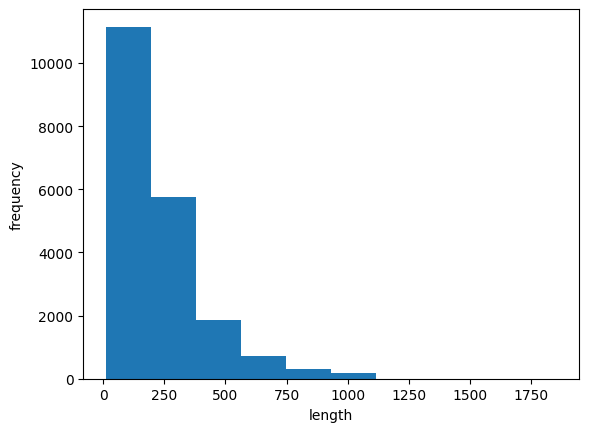

In [ ]:
import matplotlib.pyplot as plt

plt.hist(lengths)
plt.xlabel('length')
plt.ylabel('frequency')
plt.show()

- 대부분의 리뷰 길이는 300 미만
- 리뷰가 대부분 짧아서 이 예제에서는 중간값 보다 훨씬 짧은 100개의 단어만 사용할 것이다.
- 100개의 단어보다 작은 리뷰: 길이를 100에 맞추기 위해 **패딩** 필요
  - 패딩을 나타내는 토큰으로 0 사용

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 시퀀스 데이터의 길이를 맞추는 pad_sequence 함수
train_seq = pad_sequences(train_input, maxlen=100) # maxlen에 원하는 길이를 지정하면 이보다 긴 경우 잘라내고 짧은 경우 0으로 패딩

In [ ]:
print(train_seq.shape)

(20000, 100)


In [ ]:
# 첫 샘플 출력
print(train_seq[0])
# result : 샘플의 앞뒤에 패딩값 0이 없는 것으로 보아 100보다는 길었을 것이다.

[ 10   4  20   9   2   2   2   5  45   6   2   2  33   2   8   2 142   2
   5   2  17  73  17   2   5   2  19  55   2   2  92  66 104  14  20  93
  76   2 151  33   4  58  12 188   2 151  12   2  69   2 142  73   2   6
   2   7   2   2 188   2 103  14  31  10  10   2   7   2   5   2  80  91
   2  30   2  34  14  20 151  50  26 131  49   2  84  46  50  37  80  79
   6   2  46   7  14  20  10  10   2 158]


In [ ]:
print(train_input[0][-10:]) # 샘플의 앞과 뒤 중 어디가 잘렸을까?

[6, 2, 46, 7, 14, 20, 10, 10, 2, 158]


샘플의 끝 뒷부분과 똑같으므로 앞부분이 잘렸음을 알 수 있음

In [ ]:
print(train_seq[5]) # 여섯 번째 샘플 출력

[  0   0   0   0   1   2 195  19  49   2   2 190   4   2   2   2 183  10
  10  13  82  79   4   2  36  71   2   8   2  25  19  49   7   4   2   2
   2   2   2  10  10  48  25  40   2  11   2   2  40   2   2   5   4   2
   2  95  14   2  56 129   2  10  10  21   2  94   2   2   2   2  11 190
  24   2   2   7  94   2   2  10  10  87   2  34  49   2   7   2   2   2
   2   2   2   2  46  48  64  18   4   2]


앞부분에 0 존재 -> 샘플 길이가 100보다 짧음
- 패딩 토큰은 시퀀스의 **앞부분**에 추가됨
- 시퀀스의 마지막에 있는 단어가 셀의 은닉상태에 가장 큰 영향을 미치므로 마지막에 패딩을 추가하는 것은 일반적으로 선호하지 않음
  - 하지만 원한다면 padding 매개변수를 pre -> post로 바꾸면됨

In [ ]:
val_seq = pad_sequences(val_input, maxlen=100)

## 순환 신경망 만들기

- 이진 분류 문제이므로 마지막 출력층은 1개의 뉴런을 가지고 시그모이드 활성화 함수 사용

In [ ]:
from tensorflow import keras

model = keras.Sequential()

model.add(keras.layers.SimpleRNN(8, input_shape=(100, 200))) # ✅ 튜플로 전달
model.add(keras.layers.Dense(1, activation='sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
train_oh = keras.utils.to_categorical(train_seq) # train_Seq를 원핫인코딩으로 변환하여 train_oh 배열 만들기

In [ ]:
print(train_oh.shape)
# 정수 하나마다 모두 500차원의 배열로 변경되었기 때문에 (20000, 100) 크기의 train_seq가 (20000, 100,500) 크기의 train_oh

(20000, 100, 200)


In [ ]:
print(train_oh[0][0][:12])  # 첫 번째 샘플의 첫 번째 토큰 10이 인코딩 되었는지 확인

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


In [ ]:
print(np.sum(train_oh[0][0])) # 열한 번째 원소만 1이고 나머지는 모두 0이어서 원-핫 인코딩된 배열의 값을 모두 더한 결과가 1이 됨

1.0


In [ ]:
val_oh = keras.utils.to_categorical(val_seq) # 같은 방식으로 val_seq도 원핫 인코딩으로 바꾸어 놓기

In [ ]:
model.summary() # 모델의 구조 출력

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 8)              │         1,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,681 (6.57 KB)

 Trainable params: 1,681 (6.57 KB)

 Non-trainable params: 0 (0.00 B)

- 사용할 뉴런의 개수 input_shape에 입력 차원 (100,500)으로 지정
  - 첫번째 차원이 100인 것은 샘플의 길이를 100으로 지정했기 때문

- 순환층: 활성화 함수 사용
  - simpleRNN 클래스의 activation 매개벼수 기본값: tanh 사용

## 순환 신경망 훈련하기

- simpleRNN에 전달할 샘플의 크기는 (100,500)이지만
- 이 슨환층은 마지막 타임스텝의 은닉 상태만 출력
  - 따라서 출력 크기가 뉴런 개수와 동일한 8임을 확인 가능

< 모델 파라미터 개수 계산 >
- 입력 토큰: 500차원의 원-핫 인코딩 배열
- 배열이 순환층의 뉴런 8개와 완전히 연결 => 500*8=4000
- 순환층의 은닉 상태는 다시 다음 스텝에 사용되기 때문에 또 다른 가중치와 곱해짐
  - 이 은닉 상태도 순환층의 뉴런과 완전히 연결되기 때문에 8(은닉 상태 크기) * 8 (뉴런 개수) = 64개의 가중치가 필요
  - 뉴런마다 하나의 절편 有
  - 4000 + 64 + 8 = 4,072개의 모델 파라미터 필요

In [ ]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model.compile(optimizer=rmsprop, loss='binary_crossentropy',
              metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-simplernn-model.keras',
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)

history = model.fit(train_oh, train_target, epochs=100, batch_size=64,
                    validation_data=(val_oh, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.4945 - loss: 0.7135 - val_accuracy: 0.4924 - val_loss: 0.7053
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.5020 - loss: 0.7038 - val_accuracy: 0.4960 - val_loss: 0.7010
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.5059 - loss: 0.6993 - val_accuracy: 0.4962 - val_loss: 0.6984
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.5124 - loss: 0.6964 - val_accuracy: 0.5038 - val_loss: 0.6962
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.5154 - loss: 0.6943 - val_accuracy: 0.5110 - val_loss: 0.6939
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5195 - loss: 0.6925 - val_accuracy: 0.5120 - val_loss: 0.6925
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.5228 - loss: 0.6915 - val_accuracy: 0.5162 - val_loss: 0.6917
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.5255 - loss: 0.6905 - 

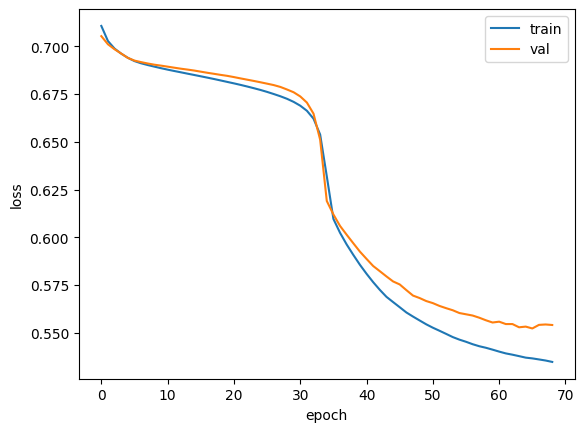

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

## 단어 임베딩을 사용하기

- 단어 임베딩: 각 단어를 고정된 크기의 실수 벡터로 바꿈
  - 단어 임베딩으로 만들어진 벡터는 원핫인코딩된 벡터보다 훨씬 의미 있는 값으로 채워짐 -> NLP에서 더 좋은 성능을 내는 경우가 많음

- 장점: 입력으로 정수 데이터를 받는다
  - 즉 원핫인코딩으로 변경된 train_oh 배열이 아니라 train_seq를 사용할 수 있음



In [ ]:
model2 = keras.Sequential()

model2.add(keras.layers.Embedding(200, 16, input_shape=(100,)))
model2.add(keras.layers.SimpleRNN(8))
model2.add(keras.layers.Dense(1, activation='sigmoid'))

model2.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 16)        │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 8)              │           200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,409 (13.32 KB)

 Trainable params: 3,409 (13.32 KB)

 Non-trainable params: 0 (0.00 B)

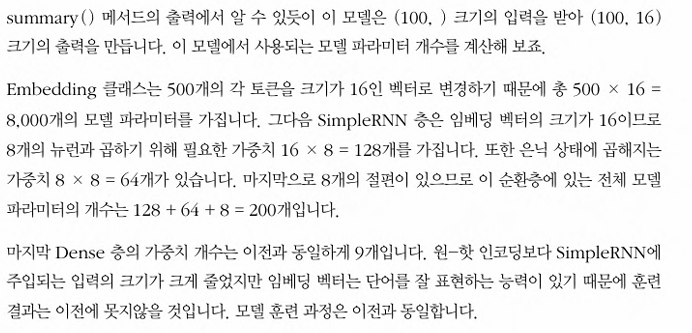

In [ ]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model2.compile(optimizer=rmsprop, loss='binary_crossentropy',
               metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-embedding-model.keras',
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)

history = model2.fit(train_seq, train_target, epochs=100, batch_size=64,
                     validation_data=(val_seq, val_target),
                     callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - accuracy: 0.5026 - loss: 0.6955 - val_accuracy: 0.4980 - val_loss: 0.6949
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.5176 - loss: 0.6925 - val_accuracy: 0.5036 - val_loss: 0.6939
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.5347 - loss: 0.6903 - val_accuracy: 0.5100 - val_loss: 0.6932
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.5454 - loss: 0.6884 - val_accuracy: 0.5122 - val_loss: 0.6926
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.5567 - loss: 0.6864 - val_accuracy: 0.5180 - val_loss: 0.6921
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.5663 - loss: 0.6844 - val_accuracy: 0.5218 - val_loss: 0.6917
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.5724 - loss: 0.6825 - val_accuracy: 0.5234 - val_loss: 0.6914
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.5744 - loss: 0.6806 -

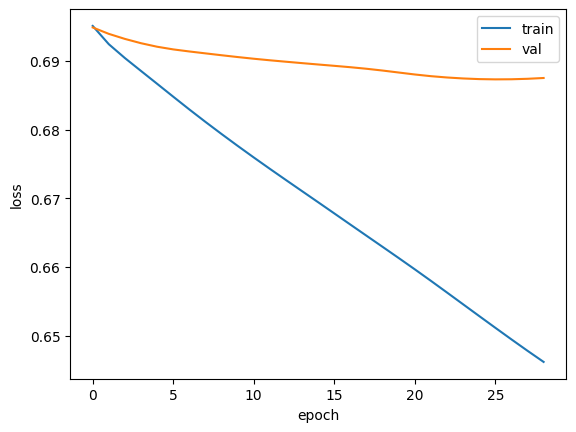

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()